In [7]:
# =========================================
# Clasificación beisbol.csv con Gradient Boosting
# =========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)


In [8]:
datos = pd.read_csv(filepath_or_buffer="C:/Users/jenif/Downloads/beisbol.csv")

In [9]:
datos

,Unnamed: 0,equipos,bateos,runs
0,0,Texas,5659,855
1,1,Boston,5710,875
2,2,Detroit,5563,787
3,3,Kansas,5672,730
4,4,St.,5532,762
5,5,New_S.,5600,718
6,6,New_Y.,5518,867
7,7,Milwaukee,5447,721
8,8,Colorado,5544,735
9,9,Houston,5598,615


In [10]:
datos['objetivo'] = (datos['runs'] > datos['runs'].mean()).astype(int)


In [11]:
# -----------------------------
# 2) Configurar TARGET y limpieza mínima
# -----------------------------
TARGET_COLUMN = "objetivo"  # <-- Cambia esto según tu dataset
y_raw = datos[TARGET_COLUMN]

if y_raw.dtype == "O" or str(y_raw.dtype).startswith("category"):
    unique_vals = sorted(y_raw.dropna().unique())
    mapping = {val: i for i, val in enumerate(unique_vals)}
    y = y_raw.map(mapping)
else:
    y = y_raw.copy()

X = datos.drop(columns=[TARGET_COLUMN])
# Eliminar columnas no informativas
for col in list(X.columns):
    if col.lower() in ["id", "unnamed: 0", "index"]:
        X = X.drop(columns=[col], errors="ignore")

In [12]:
# -----------------------------
# 3) Selección de columnas numéricas y categóricas
# -----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [13]:
# -----------------------------
# 4) Preprocesamiento
# -----------------------------
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe())
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")


In [14]:
# -----------------------------
# 5) Modelo Gradient Boosting
# -----------------------------
gb_clf = GradientBoostingClassifier(random_state=42)

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", gb_clf)
])


In [15]:
# -----------------------------
# 6) Espacio de búsqueda de hiperparámetros
# -----------------------------
param_distributions = {
    "clf__n_estimators": [100, 200, 300, 400],
    "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "clf__max_depth": [3, 4, 5, 6],
    "clf__subsample": [0.7, 0.8, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)


In [16]:
# -----------------------------
# 7) Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rs.fit(X_train, y_train)
print("\nMejor AUC-ROC (CV):", rs.best_score_)
print("Mejores hiperparámetros:", rs.best_params_)

best_model = rs.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejor AUC-ROC (CV): 1.0
Mejores hiperparámetros: {'clf__subsample': 0.7, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.2}


In [17]:
# -----------------------------
# 8) Evaluación en test
# -----------------------------
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

print("\n=== Métricas en Test ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")



=== Métricas en Test ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
ROC-AUC  : 1.0000


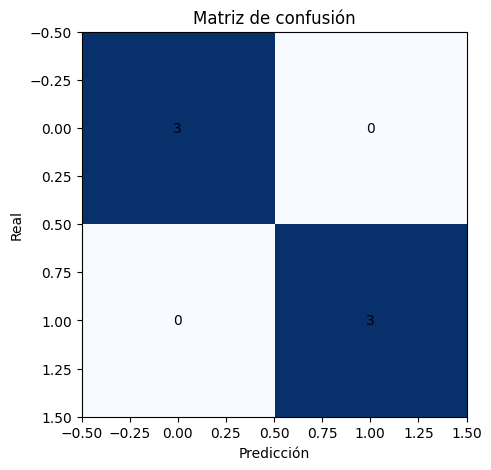

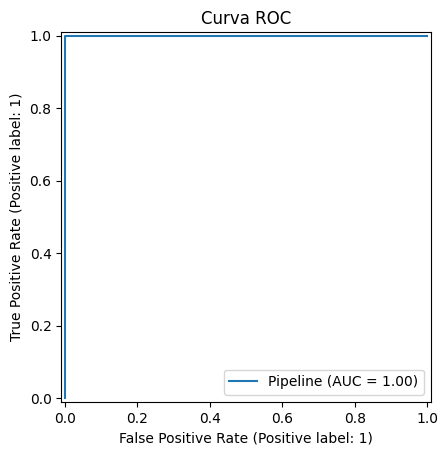

In [18]:
# -----------------------------
# 9) Gráficas
# -----------------------------
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
for (i,j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha="center", va="center")
plt.grid(False)
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva ROC")
plt.show()


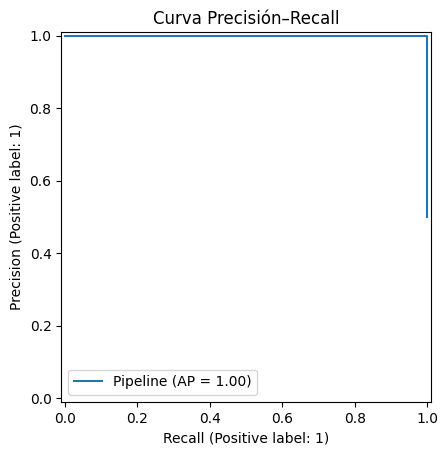

In [19]:

# Curva Precision-Recall
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva Precisión–Recall")
plt.show()


In [20]:
# -----------------------------
# 10) Guardar modelo
# -----------------------------
os.makedirs("model", exist_ok=True)
joblib.dump(best_model, "model/gb_beisbol.pkl")
print("\nModelo guardado ")


Modelo guardado 
